**Sistem Rekomendasi Restoran dengan Model Development Content Based Filtering dan Collaborative Filtering**

Dataset: https://archive.ics.uci.edu/dataset/232/restaurant+consumer+data

# **Data Loading and Data Understanding**

In [ ]:
# Impor library
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
!mkdir RestaurantConsumer
!wget https://archive.ics.uci.edu/static/public/232/restaurant+consumer+data.zip -P /content/RestaurantConsumer/

--2024-02-15 15:27:52--  https://archive.ics.uci.edu/static/public/232/restaurant+consumer+data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/RestaurantConsumer/restaurant+consumer+data.zip’

restaurant+consumer     [ <=>                ]  38.74K  --.-KB/s    in 0.07s   

2024-02-15 15:27:52 (590 KB/s) - ‘/content/RestaurantConsumer/restaurant+consumer+data.zip’ saved [39674]



In [ ]:
!unzip /content/RestaurantConsumer/restaurant+consumer+data.zip -d /content/RestaurantConsumer/

Archive:  /content/RestaurantConsumer/restaurant+consumer+data.zip
  inflating: /content/RestaurantConsumer/chefmozaccepts.csv  
  inflating: /content/RestaurantConsumer/chefmozcuisine.csv  
  inflating: /content/RestaurantConsumer/chefmozhours4.csv  
  inflating: /content/RestaurantConsumer/chefmozparking.csv  
  inflating: /content/RestaurantConsumer/geoplaces2.csv  
  inflating: /content/RestaurantConsumer/rating_final.csv  
  inflating: /content/RestaurantConsumer/README  
  inflating: /content/RestaurantConsumer/usercuisine.csv  
  inflating: /content/RestaurantConsumer/userpayment.csv  
  inflating: /content/RestaurantConsumer/userprofile.csv  


Diketahui terdapat 9 file dengan format CSV. Berdasarkan hal tersebut dapat dibagi menjadi 3 kategori, yaitu Restaurant, Consumers, dan User-Item-Rating.

**1. Restaurants**
- chefmozaccepts.csv
- chefmozcuisine.csv
- chefmozhours4.csv
- chefmozparking.csv
- geoplaces2.csv

**2. Consumers**
- usercuisine.csv
- userpayment.csv
- userprofile.csv

**3. User-Item-Rating**
- rating_final.csv

_________________________________________

In [ ]:
# Membuat variabel yang menampung data
accepts = pd.read_csv('/content/RestaurantConsumer/chefmozaccepts.csv')
cuisine = pd.read_csv('/content/RestaurantConsumer/chefmozcuisine.csv')
hours = pd.read_csv('/content/RestaurantConsumer/chefmozhours4.csv')
parking = pd.read_csv('/content/RestaurantConsumer/chefmozparking.csv')
geo = pd.read_csv('/content/RestaurantConsumer/geoplaces2.csv', encoding = "ISO-8859-1")
usercuisine = pd.read_csv('/content/RestaurantConsumer/usercuisine.csv')
payment = pd.read_csv('/content/RestaurantConsumer/userpayment.csv')
profile = pd.read_csv('/content/RestaurantConsumer/userprofile.csv')
rating = pd.read_csv('/content/RestaurantConsumer/rating_final.csv')

# **Univariate Exploratory Data Analysis**

Variabel-variabel pada Restaurant UCI dataset adalah sebagai berikut:

- accepts : Merupakan jenis pembayaran yang diterima pada restoran tertentu.
- cuisine : Merupakan jenis masakan yang disajikan pada restoran.
- hours : Merupakan jadwal buka dan tutupnya restoran.
- parking : Merupakan ketersediaan tempat parkir pada restoran.
- geo : Merupakan letak geografis restoran.
- usercuisine : Merupakan jenis masakan dari data pengguna.
- payment : Merupakan jenis pembayaran yang dipakai pengguna.
- profile : Merupakan data profil pengguna.
- rating : Merupakan rating yang diberikan consumers terhadap restoran.

pada proyek ini, variabel yang akan dieksplorasi, yaitu "accepts", "cuisine", "profile", dan "rating".

Variabel "cuisine" dan "rating" akan digunakan pada model rekomendasi. Sedangkan, variabel "accepts" dan "profile" hanya untuk melihat bagaimana profil dan jenis pembayaran yang digunakan oleh pengguna.

## **Variabel Accepts**

Melakukan eksplorasi variabel "accepts", yaitu jenis pembayaran yang diterima pada restoran tertentu.

In [ ]:
accepts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   placeID   1314 non-null   int64 
 1   Rpayment  1314 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.7+ KB


Berdasarkan output di atas, dapat diketahui bahwa "accepts" memiliki 1314 entri. Pada tahap Data Loading and Data Understanding sebelumnya, "accepts" termasuk ke dalam kategori data Restaurant. Diketahui dari output diatas, terdapat dua fitur pada "accepts", yaitu 'placeID' dan 'Rpayment'. 'PlaceID' merupakan ID restoran, sedangkan 'Rpayment' merupakan jenis pembayaran yang digunakan pada restoran.

Melihat ada berapa banyak entri yang unik berdasarkan fitur 'placeID' dan jenis-jenis pembayaran unik yang diterima.

In [ ]:
print('Banyak Restoran                :', len(accepts['placeID'].unique()))
print('Jenis Pembayaran yang diterima :', accepts['Rpayment'].unique())

Banyak Restoran                : 615
Jenis Pembayaran yang diterima : ['cash' 'VISA' 'MasterCard-Eurocard' 'American_Express' 'bank_debit_cards'
 'checks' 'Discover' 'Carte_Blanche' 'Diners_Club' 'Visa'
 'Japan_Credit_Bureau' 'gift_certificates']


## **Variabel Cuisine**

Mengeksplorasi variabel "cuisine", yaitu jenis masakan yang tersedia di restoran. Variabel "cuisine" ini termasuk ke dalam kategori data Restaurant.

In [ ]:
# Mengecek informasi pada data variabel "cuisine"
cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   placeID   916 non-null    int64 
 1   Rcuisine  916 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


Melihat ada berapa banyak entri yang unik berdasarkan jenis masakan ('Rcuisine') dan jenis-jenis masakan unik yang tersedia.

In [ ]:
print('Banyak jenis masakan :', len(cuisine['Rcuisine'].unique()))
print('jenis masakan        :', cuisine['Rcuisine'].unique())

Banyak jenis masakan : 59
jenis masakan        : ['Spanish' 'Italian' 'Latin_American' 'Mexican' 'Fast_Food' 'Burgers'
 'Dessert-Ice_Cream' 'Hot_Dogs' 'Steaks' 'Asian' 'International'
 'Mongolian' 'Vegetarian' 'Brazilian' 'Cafe-Coffee_Shop' 'Cafeteria'
 'Contemporary' 'Deli-Sandwiches' 'Diner' 'Japanese' 'Sushi' 'Seafood'
 'Chinese' 'Bar' 'Bar_Pub_Brewery' 'Pizzeria' 'Mediterranean' 'American'
 'Family' 'Caribbean' 'African' 'Breakfast-Brunch' 'Regional' 'Afghan'
 'Bakery' 'Game' 'Armenian' 'Vietnamese' 'Korean' 'Thai' 'Barbecue'
 'Polish' 'Dutch-Belgian' 'French' 'German' 'Southwestern' 'Persian'
 'Ethiopian' 'Juice' 'Soup' 'Continental-European' 'Greek' 'Southern'
 'Eastern_European' 'California' 'Bagels' 'Turkish' 'Organic-Healthy'
 'Fine_Dining']


Data "cuisine" ini akan digunakan untuk memprediksi top-N rekomendasi bagi pengguna.

## **Variabel Profile**
Profile pengguna terkadang diperlukan untuk memahami pola preferensi terhadap suatu item.

Melihat jumlah kolom dan baris pada variabel "profile".

In [ ]:
print(profile.shape)

(138, 19)


Melihat fitur apa saja yang terdapat pada variabel "profile".

In [ ]:
# Menampilkan data pada variabel "profile"
profile

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,U1134,22.149654,-100.998610,false,casual drinker,no preference,family,public,single,independent,1991,variety,hard-worker,Catholic,student,black,52,medium,1.65
134,U1135,22.170396,-100.949936,false,casual drinker,informal,family,on foot,single,kids,1988,variety,hunter-ostentatious,Catholic,student,purple,66,low,1.54
135,U1136,22.149607,-100.997235,true,social drinker,no preference,friends,car owner,single,independent,1990,retro,thrifty-protector,Catholic,student,black,50,low,1.60
136,U1137,22.144803,-100.944623,false,social drinker,formal,family,public,single,independent,1989,eco-friendly,hard-worker,Catholic,student,blue,72,low,1.78


Didapatkan berbagai fitur mulai dari 'marital_status', 'birth_year', 'smoker', 'religion', 'budget', dan lain-lain.

Pada pengembangan model dengan content-based filtering, data yang dibutuhkan nantinya adalah nama restoran dan jenis masakan. Dengan ini akan dihitung kesamaan (similarity) nama restoran dan jenis masakan kemudian membuat rekomendasi berdasarkan kesamaan ini.

## **Variabel Rating**
Mengeksplorasi data yang akan digunakan pada model yaitu data "rating".

Melihat kolom/fitur pada variabel "rating".

In [ ]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


Dari output diatas dapat diketahui bahwa data "rating" terdiri dari 5 fitur dengan tiga kategori rating. Fitur-fitur tersebut antara lain:

- userID merupakan ID pengguna.
- placeID merupakan ID restoran.
- rating merupakan data penilaian untuk restoran.
- food_rating merupakan data penilaian untuk makanan atau masakan di restoran tersebut.
- service_rating merupakan data penilaian layanan restoran tersebut.

Melihat distribusi rating pada data.

In [ ]:
rating.describe()

,placeID,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000,1161.000000
mean,134192.041344,1.199828,1.215332,1.090439
std,1100.916275,0.773282,0.792294,0.790844
min,132560.000000,0.000000,0.000000,0.000000
25%,132856.000000,1.000000,1.000000,0.000000
50%,135030.000000,1.000000,1.000000,1.000000
75%,135059.000000,2.000000,2.000000,2.000000
max,135109.000000,2.000000,2.000000,2.000000


Dari output di atas, diketahui bahwa nilai maksimum rating adalah 2 dan nilai minimumnya adalah 0. Artinya, skala rating berkisar antara 0 hingga 2.

In [ ]:
# Melihat jumlah data pelanggan yang memberikan rating, data restoran, dan data rating.
print('Jumlah userID      :', len(rating.userID.unique()))
print('Jumlah placeID     :', len(rating.placeID.unique()))
print('Jumlah data rating :', len(rating))

Jumlah userID      : 138
Jumlah placeID     : 130
Jumlah data rating : 1161


# **Data Preprocessing**

## **Menggabungkan Restoran**
Sebelumnya, 9 file dengan format CSV dibagi kedalam 3 kategori, yaitu Restaurant, User, dan User-Item-Rating. Pada tahap ini, seluruh data pada kategori Restaurant akan digabungkan. Sehingga fitur 'placeID' yang unik digunakan sebagai acuan dalam penggabungan ini.

In [ ]:
# Menggabungkan seluruh fitur 'placeID' pada kategori Restaurant
resto_all = np.concatenate((
    accepts.placeID.unique(),
    cuisine.placeID.unique(),
    hours.placeID.unique(),
    parking.placeID.unique(),
    geo.placeID.unique()
))

# Mengurutkan data dan menghapus data yang sama
resto_all = np.sort(np.unique(resto_all))

print('Jumlah seluruh data restoran berdasarkan placeID :', len(resto_all))

Jumlah seluruh data restoran berdasarkan placeID : 938


Setelah file pada kategori Restaurant digabungkan, didapatkan sebanyak 938 restoran yang unik.

## **Menggabungkan Seluruh User**
Menggabungkan seluruh data pada kategori User.

In [ ]:
# Menggabungkan seluruh fitur 'userID'
user_all = np.concatenate((
    usercuisine.userID.unique(),
    payment.userID.unique(),
    profile.userID.unique()
))

# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user :', len(user_all))

Jumlah seluruh user : 138


Diketahui hanya terdapat 138 data pengguna dari 938 restoran yang memiliki rating, maka perlu dilakukan eksplorasi dan analisis lanjutan.

## **Mengetahui Jumlah Rating**
Melihat jumlah seluruh rating dari berbagai data.

In [ ]:
# Menggabungkan variabel "accepts", "geo", "parking", "hours" ke dalam dataframe resto_info
resto_info = pd.concat([accepts, geo, parking, hours])

# Menggabungkan dataframe rating dengan resto_info berdasarkan nilai 'placeID'
resto = pd.merge(rating, resto_info , on='placeID', how='left')
resto

,userID,placeID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
0,U1077,135085,2,2,2,cash,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U1077,135085,2,2,2,NaN,22.150802,-100.982680,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,...,no_accessibility,medium,?,familiar,f,closed,none,NaN,NaN,NaN
2,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,public,NaN,NaN
3,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;
4,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Sat;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,U1068,132660,0,0,0,NaN,23.752943,-99.164679,0101000020957F00003D7905C9DC8157C13FCD1AB7334E...,carnitas mata calle Emilio Portes Gil,...,completely,low,?,familiar,f,closed,none,NaN,NaN,NaN
8074,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN
8075,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
8076,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Sat;


Diketahui terdapat banyak sekali missing value.

In [ ]:
# Cek missing value dengan fungsi isnull()
resto.isnull().sum()

userID               0
placeID              0
rating               0
food_rating          0
service_rating       0
Rpayment          5781
latitude          6917
longitude         6917
the_geom_meter    6917
name              6917
address           6917
city              6917
state             6917
country           6917
fax               6917
zip               6917
alcohol           6917
smoking_area      6917
dress_code        6917
accessibility     6917
price             6917
url               6917
Rambience         6917
franchise         6917
area              6917
other_services    6917
parking_lot       6917
hours             4619
days              4619
dtype: int64

Terdapat banyak missing value pada sebagian besar fitur. Hanya fitur 'userID', 'placeID', 'rating', 'food_rating', dan 'service_rating' saja yang memiliki 0 missing value.

Selanjutnya, menghitung jumlah rating, food_rating, dan service rating berdasarkan 'placeID'

In [ ]:
# Menghitung jumlah 'rating', 'food_rating', dan 'service' kemudian menggabungkannya berdasarkan 'placeID'
resto.groupby('placeID').sum(numeric_only=True)

,rating,food_rating,service_rating,latitude,longitude
placeID,,,,,
132560,12,24,6,95.009216,-396.667653
132561,15,20,20,94.907276,-396.506024
132564,25,25,30,94.923698,-396.580739
132572,90,90,84,332.124707,-1514.890677
132583,24,24,30,75.689162,-396.937328
...,...,...,...,...,...
135088,36,42,36,113.256068,-595.319338
135104,48,80,48,166.270875,-694.179039
135106,96,96,96,221.497088,-1009.760928


## **Menggabungkan Data dengan Fitur Nama Resto**

Pertama, mendefinisikan variabel all_resto_rate dengan variabel "rating".

In [ ]:
# Mendefinisikan dataframe "rating" ke dalam variabel "all_resto_rate"
all_resto_rate = rating
all_resto_rate

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


Selanjutnya, untuk mengetahui nama restoran dengan 'placeID' tertentu, data "geo" yang berisi 'placeID' dan nama restoran akan digabungkan berdasarkan 'placeID'. Hasil penggabungan tersebut akan di-assign ke variabel "all_resto_name".

In [ ]:
# Menggabungkan "all resto_rate" dengan dataframe geo berdasarkan 'placeID'
all_resto_name = pd.merge(all_resto_rate, geo[['placeID','name']], on='placeID', how='left')

all_resto_name

,userID,placeID,rating,food_rating,service_rating,name
0,U1077,135085,2,2,2,Tortas Locas Hipocampo
1,U1077,135038,2,2,1,Restaurant la Chalita
2,U1077,132825,2,2,2,puesto de tacos
3,U1077,135060,1,2,2,Restaurante Marisco Sam
4,U1068,135104,1,1,2,vips
...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,palomo tec
1157,U1011,132715,1,1,0,tacos de la estacion
1158,U1068,132733,1,1,0,Little Cesarz
1159,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec


## **Menggabungkan Data dengan Fitur masakan Resto**

Langkah selanjutnya adalah menggabungkan variabel "all_resto_name" dengan fitur jenis masakan ('cuisine') untuk mengetahui jenis masakan yang disediakan oleh restoran.

In [ ]:
# Menggabungkan dataframe cuisine dengan "all_resto_name" dan memasukkannya ke dalam variabel "all_resto"
all_resto = pd.merge(all_resto_name, cuisine, on='placeID', how='left')
all_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
1,U1077,135038,2,2,1,Restaurant la Chalita,NaN
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
...,...,...,...,...,...,...,...
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican


Maka inilah data yang akan digunakan untuk membuat sistem rekomendasi.

# **Data Preparation**

## **Mengatasi Missing Value**


Setelah proses penggabungan, mengecek lagi apakah masih terdapat missing value.

In [ ]:
# Mengecek missing value pada dataframe "all_resto"
all_resto.isnull().sum()

userID              0
placeID             0
rating              0
food_rating         0
service_rating      0
name                0
Rcuisine          288
dtype: int64

Terdapat 288 missing value pada fitur 'Rcuisine' (jenis masakan). 288 dari 1331 merupakan jumlah yang signifikan. Sebenarnya sayang jika data missing value ini dilakukan drop. Namun, tidak dapat diidentifikasi nama masakan yang tidak memiliki data 'Rcuisine' ini termasuk ke dalam jenis masakan mana. Oleh karena itu, akan dilakukan fungsi drop pada missing value ini.

In [ ]:
# Membersihkan missing value dengan fungsi dropna()
all_resto_clean = all_resto.dropna()
all_resto_clean

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
5,U1068,132740,0,0,0,Carreton de Flautas y Migadas,Mexican
...,...,...,...,...,...,...,...
1325,U1043,132732,1,1,1,Taqueria EL amigo,Mexican
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria


In [ ]:
# Mengecek kembali missing value pada variabel "all_resto_clean"
all_resto_clean.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
name              0
Rcuisine          0
dtype: int64

## **Menyamakan Jenis Masakan**
Sebelum masuk tahap akhir (pemodelan), perlu untuk menyamakan nama masakan. Terkadang, masakan yang sama memiliki nama atau kategori yang berbeda. Jika dibiarkan, hal ini bisa menyebabkan bias pada data.

Mengecek ulang data setelah proses cleaning pada tahap sebelumnya.

In [ ]:
# Mengurutkan resto berdasarkan 'PlaceID' kemudian memasukkannya ke dalam variabel "fix_resto"
fix_resto = all_resto_clean.sort_values('placeID', ascending=True)
fix_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
438,U1024,135106,1,1,1,El Rincón de San Francisco,Mexican
178,U1020,135109,2,2,1,Paniroles,Italian
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian


Terdapat 1.043 baris data. Selanjutnya mengecek jumlah restoran yang mencakup data tersebut.

In [ ]:
# Mengecek berapa jumlah fix_resto
len(fix_resto.placeID.unique())

95

Selanjutnya, mengecek 'Rcuisine' (jenis masakan) yang unik.

In [ ]:
# Mengecek jenis masakan yang unik
fix_resto.Rcuisine.unique()

array(['Regional', 'Cafeteria', 'American', 'Mexican', 'Fast_Food',
       'Italian', 'Armenian', 'Pizzeria', 'Japanese', 'Vietnamese',
       'Family', 'International', 'Game', 'Burgers', 'Bakery', 'Bar',
       'Breakfast-Brunch', 'Bar_Pub_Brewery', 'Mediterranean',
       'Cafe-Coffee_Shop', 'Contemporary', 'Seafood', 'Chinese'],
      dtype=object)

Diantara semua jenis masakan pada data, ada satu yang menarik, yaitu jenis masakan bernama Game. Sehingga perlu dilakukan eksplorasi dan analisis lanjutan.

Melihat nama restoran yang memiliki jenis masakan Game.

In [ ]:
# Mengecek jenis masakan Game
fix_resto[fix_resto['Rcuisine'] == 'Game']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
509,U1052,132851,1,0,2,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
770,U1037,132851,2,2,1,KFC,Game
574,U1069,132851,1,0,0,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
764,U1111,132851,2,1,0,KFC,Game


Diketahui jenis masakan Game ada pada restoran KFC. Selanjutnya, mengecek jenis masakan ('Rcuisine') lain dari restoran KFC.

In [ ]:
# Mengecek jenis masakan pada nama restoran KFC
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
508,U1052,132851,1,0,2,KFC,American
780,U1015,132851,1,1,1,KFC,American
509,U1052,132851,1,0,2,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
707,U1008,132851,1,1,1,KFC,American
770,U1037,132851,2,2,1,KFC,Game
769,U1037,132851,2,2,1,KFC,American
1187,U1131,132851,2,2,2,KFC,American
574,U1069,132851,1,0,0,KFC,Game


Diketahui KFC memiliki dua jenis masakan yang berbeda, yaitu Game dan American. Dalam sistem rekomendasi yang akan dikembangkan, satu restoran memiliki satu jenis masakan. Dalam hal ini, KFC lebih cocok disebut sebagai restoran dengan jenis masakan American. Jadi, perlu mengganti jenis Game dengan American.

In [ ]:
# Mengubah nama jenis masakan Game menjadi American
fix_resto = fix_resto.replace('Game', 'American')
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,American
508,U1052,132851,1,0,2,KFC,American
780,U1015,132851,1,1,1,KFC,American
509,U1052,132851,1,0,2,KFC,American
708,U1008,132851,1,1,1,KFC,American
707,U1008,132851,1,1,1,KFC,American
770,U1037,132851,2,2,1,KFC,American
769,U1037,132851,2,2,1,KFC,American
1187,U1131,132851,2,2,2,KFC,American
574,U1069,132851,1,0,0,KFC,American


Semua jenis masakan Game telah berubah menjadi American. Kini, restoran KFC telah memiliki satu jenis masakan, yaitu American. Dalam sistem rekomendasi yang dikembangkan, penting untuk memastikan satu restoran mewakili satu jenis masakan. Tujuannya supaya tidak terjadi dobel atau rangkap jenis dalam satu restoran. Sehingga, sistem dapat merekomendasikan resto berdasarkan jenis masakannya.

Selanjutnya dapat dilakukan tahap persiapan.

In [ ]:
# Membuat variabel "preparation" yang berisi dataframe "fix_resto" kemudian mengurutkan berdasarkan 'placeID'
preparation = fix_resto
preparation.sort_values('placeID')

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
184,U1055,132572,2,2,2,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
1224,U1002,135106,1,1,1,El Rincón de San Francisco,Mexican
99,U1030,135109,0,0,0,Paniroles,Italian
178,U1020,135109,2,2,1,Paniroles,Italian
1071,U1041,135109,1,2,1,Paniroles,Italian


Selanjutnya, hanya akan digunakan data unik untuk dimasukkan ke dalam proses pemodelan. Oleh karena itu, data yang duplikat perlu dihapus. Dalam hal ini, data duplikat pada fitur 'placeID' akan dihapus.

In [ ]:
# Membuang data duplikat pada variabel "preparation" berdasarkan 'placeID'
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
168,U1118,132583,0,0,0,McDonalds Centro,American
24,U1107,132584,2,2,2,Gorditas Dona Tota,Mexican
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...,...,...,...,...
681,U1095,135086,1,2,1,Mcdonalds Parque Tangamanga,Fast_Food
175,U1020,135088,1,2,0,Cafeteria cenidet,Cafeteria
4,U1068,135104,1,1,2,vips,Mexican
488,U1004,135106,2,2,2,El Rincón de San Francisco,Mexican


Selanjutnya, dilakukan konversi data series menjadi list dengan menggunakan fungsi tolist() dari library numpy.

In [ ]:
# Mengonversi data series 'placeID' menjadi dalam bentuk list
resto_id = preparation['placeID'].tolist()

# Mengonversi data series 'Name' menjadi dalam bentuk list
resto_name = preparation['name'].tolist()

# Mengonversi data series 'Rcuisine' menjadi dalam bentuk list
resto_cuisine = preparation['Rcuisine'].tolist()

print(len(resto_id))
print(len(resto_name))
print(len(resto_cuisine))

95
95
95


Tahap berikutnya, membuat dictionary untuk menentukan pasangan key-value pada data 'resto_id', 'resto_name', dan 'resto_cuisine' yang telah disiapkan sebelumnya.

In [ ]:
# Membuat dictionary untuk data 'resto_id', 'resto_name', dan 'resto_cuisine'
resto_new = pd.DataFrame({
    'id': resto_id,
    'resto_name': resto_name,
    'cuisine': resto_cuisine
})
resto_new

,id,resto_name,cuisine
0,132560,puesto de gorditas,Regional
1,132572,Cafe Chaires,Cafeteria
2,132583,McDonalds Centro,American
3,132584,Gorditas Dona Tota,Mexican
4,132594,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...
90,135086,Mcdonalds Parque Tangamanga,Fast_Food
91,135088,Cafeteria cenidet,Cafeteria
92,135104,vips,Mexican
93,135106,El Rincón de San Francisco,Mexican


Data telah siap untuk dimasukkan ke dalam pemodelan.

# **Model Development dengan Content Based Filtering**
Content Based Filtering bekerja berdasarkan karakteristik atau konten dari item yang direkomendasikan. Pendekatan ini mempertimbangkan preferensi pengguna di masa lalu berdasarkan pada fitur atau atribut dari item tersebut.

Pertama, melakukan assign dataframe dari tahap sebelumnya ke dalam variabel data.

In [ ]:
data_resto = resto_new
data_resto.sample(5)

,id,resto_name,cuisine
33,132856,Unicols Pizza,Italian
2,132583,McDonalds Centro,American
91,135088,Cafeteria cenidet,Cafeteria
59,135026,la Cantina,Bar_Pub_Brewery
66,135039,Restaurant de Mariscos de Picon,Seafood


## **TF-IDF Vectorizer**
Selanjutnya, menemukan representasi fitur penting dari setiap jenis masakan menggunakan TF-IDF Vectorizer.

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(data_resto['cuisine'])

# Mapping array dari fitur index integer ke fitur nama
feature_names = tf.get_feature_names_out()

print(feature_names)

['american' 'armenian' 'bar' 'bar_pub_brewery' 'breakfast' 'brunch'
 'burgers' 'cafe' 'cafeteria' 'chinese' 'coffee_shop' 'contemporary'
 'family' 'fast_food' 'international' 'italian' 'japanese' 'mexican'
 'pizzeria' 'regional' 'seafood' 'vietnamese']


Selanjutnya, melakukan fit dan transformasi kedalam bentuk matriks.

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data_resto['cuisine'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(95, 22)

Matriks berukuran (95, 22). Nilai 95 merupakan ukuran data dan 22 merupakan matrik jenis masakan.

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, digunakan fungsi todense().

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Selanjutnya, melihat matriks tf-idf untuk beberapa resto ('resto_name') dan jenis masakan ('Rcuisine') untuk mengidentifikasi korelasi antara restoran dengan jenis masakan.

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),   # Kolom diisi jenis masakan
    index=data_resto.resto_name   # Baris diisi nama resto
).sample(22, axis=1).sample(10, axis=0)

,seafood,bar_pub_brewery,japanese,bar,american,contemporary,vietnamese,brunch,regional,coffee_shop,...,breakfast,armenian,italian,cafeteria,international,pizzeria,cafe,mexican,burgers,chinese
resto_name,,,,,,,,,,,,,,,,,,,,,
el lechon potosino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Dominos Pizza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
emilianos,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TACOS CORRECAMINOS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Restaurante y Pescaderia Tampico,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sirlone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
La Cantina Restaurante,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
El Mundo de la Pasta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subway,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Output matriks tf-idf di atas menunjukkan **emilianos** memiliki jenis **bar_pub_brewery**. Hal ini terlihat dari nilai matriks 1.0 pada jenis **bar_pub_brewery**. Selanjutnya, **Restaurante y Pescaderia Tampico** termasuk dalam kategori **seafood**. Demikian seterusnya.

Selanjutnya, akan dihitung derajat kesamaan (similarity) antara satu restoran dengan restoran lainnya untuk menghasilkan kandidat restoran yang akan direkomendasikan.

## **Cosine Similarity**
Menghitung derajat kesamaan (similarity degree) antar restoran dengan teknik cosine similarity.

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Selanjutnya, melihat matriks kesamaan setiap resto dengan menampilkan nama restoran dalam 5 sampel kolom (axis = 1) dan 10 sampel baris (axis=0).

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_resto['resto_name'], columns=data_resto['resto_name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (95, 95)


resto_name,tortas hawai,Hamburguesas La perica,carnitas_mata,Restaurant Bar Hacienda los Martinez,Luna Cafe
resto_name,,,,,
tacos abi,0.0,1.0,1.0,0.0,0.0
La Estrella de Dimas,0.0,1.0,1.0,0.0,0.0
Hamburguesas Valle Dorado,0.0,0.0,0.0,0.0,0.0
Subway,1.0,0.0,0.0,0.0,0.0
La Posada del Virrey,0.0,0.0,0.0,0.0,0.0
Kiku Cuernavaca,0.0,0.0,0.0,0.0,0.0
el lechon potosino,0.0,0.0,0.0,0.0,0.0
Hamburguesas La perica,0.0,1.0,1.0,0.0,0.0
Log Yin,0.0,0.0,0.0,0.0,0.0


Pada output matriks di atas. Angka 1.0 mengindikasikan bahwa restoran pada kolom X (horizontal) memiliki kesamaan dengan restoran pada baris Y (vertikal). Sebagai contoh, resto **Hamburguesas La perica** dan resto **carnitas_mata** teridentifikasi mirip (similar) dengan resto **tacos abi**.

Dengan data kesamaan (similarity) restoran yang diperoleh sebelumnya, selanjutnya akan dilakukan rekomendasi daftar resto yang mirip (similar) dengan resto yang sebelumnya pernah dikunjungi pelanggan.

## **Mendapatkan Rekomendasi Restoran**
Skema pada sistem rekomandasi kali ini adalah, sebagai contoh seperti matriks sebelumnya, pengguna X pernah memesan makanan dari resto **tacos abi**. Kemudian, saat pengguna tersebut berencana untuk memesan makanan di restoran lain, sistem akan merekomendasikan resto **Hamburguesas La perica** dan resto **carnitas_mata**. Rekomendasi kedua restoran ini berdasarkan kesamaan yang dihitung dengan cosine similarity pada tahap sebelumnya.

Selanjutnya membuat fungsi resto_recommendations dengan beberapa parameter sebagai berikut:

- Nama_resto : Nama restoran (index kemiripan dataframe).
- Similarity_data : Dataframe mengenai similarity yang telah didefinisikan sebelumnya.
- Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah 'resto_name' dan 'cuisine'.
- k : Banyak rekomendasi yang ingin diberikan.

Keluaran sistem rekomendasi adalah berupa top-N recommendation. Oleh karena itu, akan memberikan sejumlah rekomendasi buku pada pengguna yang diatur dalam parameter k.

In [ ]:
# Rekomendasi Resto berdasarkan kemiripan dataframe
def resto_recommendations(nama_resto, similarity_data=cosine_sim_df, items=data_resto[['resto_name', 'cuisine']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_resto].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_resto, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Selanjutnya, menemukan rekomendasi restoran yang mirip dengan KFC.

In [ ]:
data_resto[data_resto.resto_name.eq('KFC')]

,id,resto_name,cuisine
31,132851,KFC,American


KFC masuk dalam kategori cuisine American.

In [ ]:
# Mendapatkan rekomendasi restoran yang mirip dengan KFC
resto_recommendations('KFC')

,resto_name,cuisine
0,VIPS,American
1,tacos los volcanes,American
2,Pizzeria Julios,American
3,Sirlone,International
4,McDonalds Centro,American


Sistem telah berhasil memberikan rekomendasi 5 nama restoran yang mirip dengan KFC dengan kategori American dan kategori International.

## **Evaluasi Content-Based Filtering**

Dengan menggunakan argpartition, diambil sejumlah nilai k tertinggi dari similarity data (dalam kasus ini: dataframe cosine_sim_df). Kemudian, diambil data dari bobot (tingkat kesamaan) tertinggi ke terendah. Data ini dimasukkan ke dalam variabel "closest". Berikutnya, perlu menghapus nama_resto yang dicari agar tidak muncul dalam daftar rekomendasi. Dalam kasus ini, nanti akan dicari resto yang mirip dengan KFC, sehingga perlu drop nama_resto KFC agar tidak muncul dalam daftar rekomendasi yang diberikan nanti.  

Dalam kasus ini, mencari restoran yang mirip dengan restoran KFC, sehingga perlu drop nama restoran tersebut agar tidak muncul dalam daftar rekomendasi yang diberikan nanti.

# **Model Development dengan Collaborative Filtering**
Pada teknik Collaborative Filtering akan dapat menghasilkan rekomendasi sejumlah restoran yang sesuai dengan preferensi pengguna berdasarkan rating yang telah diberikan pengguna sebelumnya. Dari data rating pengguna tersebut, akan diidentifikasi restoran-restoran yang mirip dan belum pernah dikunjungi oleh pengguna untuk direkomendasikan.

In [ ]:
# Impor library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Untuk memudahkan agar tidak tertukar dengan variabel "rating" pada data, dibuat variabel "df" yang berisi data "rating".

In [ ]:
df = rating
df

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


## **Data Preparation**
Pada tahap ini, dilakukan persiapan data untuk menyandikan (encode) fitur 'user' dan 'placeID' kedalam indeks integer.

In [ ]:
# Mengubah 'userID' menjadi list tanpa nilai yang sama
user_ids = df['userID'].unique().tolist()
print('list userID             :', user_ids)

# Melakukan encoding 'userID'
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID          :', user_to_user_encoded)

# Melakukan proses encoding angka ke ke 'userID'
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID :', user_encoded_to_user)

list userID             : ['U1077', 'U1068', 'U1067', 'U1103', 'U1107', 'U1044', 'U1070', 'U1031', 'U1082', 'U1023', 'U1060', 'U1015', 'U1123', 'U1021', 'U1026', 'U1083', 'U1108', 'U1012', 'U1093', 'U1030', 'U1066', 'U1127', 'U1017', 'U1100', 'U1133', 'U1118', 'U1072', 'U1080', 'U1063', 'U1074', 'U1117', 'U1020', 'U1051', 'U1055', 'U1053', 'U1035', 'U1064', 'U1081', 'U1001', 'U1014', 'U1088', 'U1056', 'U1134', 'U1106', 'U1126', 'U1124', 'U1018', 'U1125', 'U1119', 'U1076', 'U1022', 'U1094', 'U1116', 'U1105', 'U1075', 'U1007', 'U1115', 'U1024', 'U1132', 'U1005', 'U1120', 'U1004', 'U1037', 'U1052', 'U1036', 'U1038', 'U1071', 'U1114', 'U1084', 'U1049', 'U1019', 'U1069', 'U1113', 'U1104', 'U1079', 'U1045', 'U1009', 'U1016', 'U1047', 'U1095', 'U1034', 'U1078', 'U1099', 'U1008', 'U1040', 'U1121', 'U1110', 'U1042', 'U1013', 'U1054', 'U1111', 'U1128', 'U1062', 'U1101', 'U1135', 'U1032', 'U1048', 'U1092', 'U1085', 'U1109', 'U1102', 'U1098', 'U1046', 'U1122', 'U1138', 'U1033', 'U1089', 'U1003', '

Selanjutnya, melakukan hal yang sama pada fitur 'placeID'.

In [ ]:
# Mengubah 'placeID' menjadi list tanpa nilai yang sama
resto_ids = df['placeID'].unique().tolist()

# Melakukan proses encoding 'placeID'
resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}

# Melakukan proses encoding angka ke 'placeID'
resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}

Berikutnya, memetakan 'userID' dan 'placeID' ke dataframe yang berkaitan.

In [ ]:
# Mapping 'userID' ke dataframe "user"
df['user'] = df['userID'].map(user_to_user_encoded)

# Mapping 'placeID' ke dataframe "resto"
df['resto'] = df['placeID'].map(resto_to_resto_encoded)

Terakhir, mengecek beberapa hal dalam data seperti jumlah user, jumlah resto, dan mengubah nilai rating menjadi float.

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print('Number of Users :', (num_users))

# Mendapatkan jumlah resto
num_resto = len(resto_encoded_to_resto)
print('Number of Resto :', num_resto)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])
print('Min Rating      :', min_rating)

# Nilai maksimal rating
max_rating = max(df['rating'])
print('Max Rating      :', max_rating)

Number of Users : 138
Number of Resto : 130
Min Rating      : 0.0
Max Rating      : 2.0


Tahap persiapan telah selesai. Berikut adalah hal-hal yang telah dilakukan pada tahap ini:

- Memahami data rating yang dimiliki.
- Menyandikan (encode) fitur 'user' dan 'placeID' kedalam indeks integer.
- Memetakan 'userID' dan 'placeID' ke dataframe yang berkaitan.
- Mengecek beberapa hal dalam data seperti jumlah user, jumlah resto, kemudian mengubah nilai rating menjadi float.

Tahap persiapan penting dilakukan agar data siap digunakan untuk pemodelan. Selanjutnya, perlu untuk membagi data untuk training dan validasi.

## **Membagi Data untuk Training dan Validasi**

Mengacak data agar distribusinya menjadi random.

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userID,placeID,rating,food_rating,service_rating,user,resto
538,U1052,132870,1.0,1,1,63,116
673,U1015,132869,2.0,2,2,11,115
578,U1047,132875,0.0,0,0,78,117
242,U1056,135076,2.0,2,2,41,71
1063,U1002,135106,1.0,1,1,125,64
...,...,...,...,...,...,...,...
1044,U1073,135065,0.0,0,0,123,94
1095,U1058,135062,2.0,2,2,124,76
1130,U1087,132660,1.0,1,0,132,14
860,U1029,132937,1.0,1,1,110,126


Selanjutnya, membagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, perlu memetakan (mapping) data user dan resto menjadi satu value terlebih dahulu. Lalu, membuat rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'resto']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 63 116]
 [ 11 115]
 [ 78 117]
 ...
 [132  14]
 [110 126]
 [129   6]] [0.5 1.  0.  ... 0.5 0.5 0. ]


Data telah siap untuk dimasukkan ke dalam model.

## **Proses Training**
Pada tahap ini, model menghitung skor kecocokan antara pengguna dan resto dengan teknik embedding. Pertama, dilakukan proses embedding terhadap data user dan resto. Selanjutnya, melakukan operasi perkalian dot product antara embedding user dan resto. Selain itu, menambahkan bias untuk setiap user dan resto. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Pada tahap ini membuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs [Keras](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) dengan beberapa adaptasi sesuai kasus yang sedang diselesaikan.

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(   # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)  # layer embedding user bias
    self.resto_embedding = layers.Embedding(   # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1)   # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])   # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0])   # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1])   # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1])   # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x)   # activation sigmoid

Selanjutnya, melakukan proses compile terhadap model.

In [ ]:
# Inisialisasi model
model = RecommenderNet(num_users, num_resto, 50)

# Model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

Langkah berikutnya, memulai proses training yang disimpan dalam variabel history.

In [ ]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
116/116 [==============================] - 5s 12ms/step - loss: 0.7042 - root_mean_squared_error: 0.4052 - val_loss: 0.7118 - val_root_mean_squared_error: 0.4122
Epoch 2/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6789 - root_mean_squared_error: 0.3896 - val_loss: 0.7081 - val_root_mean_squared_error: 0.4101
Epoch 3/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6638 - root_mean_squared_error: 0.3802 - val_loss: 0.7021 - val_root_mean_squared_error: 0.4065
Epoch 4/100
116/116 [==============================] - 0s 4ms/step - loss: 0.6499 - root_mean_squared_error: 0.3715 - val_loss: 0.6976 - val_root_mean_squared_error: 0.4037
Epoch 5/100
116/116 [==============================] - 0s 2ms/step - loss: 0.6463 - root_mean_squared_error: 0.3690 - val_loss: 0.6944 - val_root_mean_squared_error: 0.4018
Epoch 6/100
116/116 [==============================] - 0s 3ms/step - loss: 0.6350 - root_mean_squared_error: 0.3617 - val_loss: 0.6921

## **Visualisasi Metrik**

Melihat visualisasi proses training dengan plot metrik evaluasi.

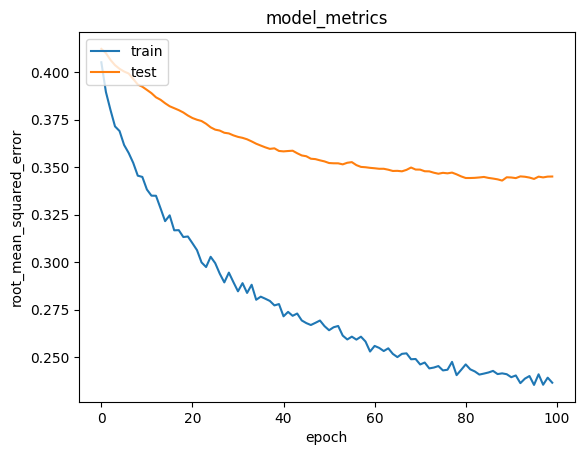

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dari plot metrik diatas, diketahui proses training model cukup smooth dan model konvergen pada epochs sekitar 100. Dari proses ini, diperoleh nilai error akhir sekitar 0.20, dan error pada data validasi sekitar 0.35. Nilai tersebut cukup bagus untuk sebuah sistem rekomendasi.

## **Mendapatkan Rekomendasi Restoran**
Untuk mendapatkan rekomendasi resto, perlu diambil sampel user secara acak dan mendefinisikan variabel resto_not_visited yang merupakan daftar resto yang belum pernah dikunjungi oleh pengguna. Daftar resto yang belum pernah dikunjungi oleh pengguna inilah yang akan menjadi resto yang direkomendasikan.

Sebelumnya, pengguna telah memberi rating pada beberapa resto yang telah mereka kunjungi. Maka dari itu rating tersebut digunakan untuk membuat rekomendasi restoran yang mungkin cocok untuk pengguna. Restoran yang akan direkomendasikan adalah restoran yang belum pernah dikunjungi oleh pengguna. Oleh karena itu, perlu membuat variabel "resto_not_visited" sebagai daftar restoran untuk direkomendasikan pada pengguna.

In [ ]:
resto_df = resto_new
df = rating

# Mengambil sample user
user_id = df['userID'].sample(1).iloc[0]
resto_visited_by_user = df[df['userID'] == user_id]

resto_not_visited = resto_df[~resto_df['id'].isin(resto_visited_by_user.placeID.values)]['id']
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)

resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

Selanjutnya, memperoleh rekomendasi restoran dengan fungsi model.predict().

In [ ]:
# Mendapatkan rekomendasi resto
ratings = model.predict(user_resto_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]

print('\nRekomendasi resto untuk user: {}'.format(user_id))
print('===' * 15)
print('\nResto dengan rating tinggi dari user: {}'.format(user_id))
print('===' * 15)

top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .placeID.values
)

resto_df_rows = resto_df[resto_df['id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.resto_name, ':', row.cuisine)

print('\nTop 10 rekomendasi resto untuk user: {}'.format(user_id))
print('===' * 15)

recommended_resto = resto_df[resto_df['id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.resto_name, ':', row.cuisine)

3/3 [==============================] - 0s 4ms/step

Rekomendasi resto untuk user: U1034

Resto dengan rating tinggi dari user: U1034
Gordas de morales : Mexican
El Mundo de la Pasta : Italian
Restaurante de Mariscos la Langosta : Seafood
Mcdonalds Parque Tangamanga : Fast_Food

Top 10 rekomendasi resto untuk user: U1034
Little Cesarz : Pizzeria
Cabana Huasteca : Mexican
La Estrella de Dimas : Mexican
Mariscos Tia Licha : Family
El cotorreo : Mexican
el lechon potosino  : International
KFC : American
La Posada del Virrey : International
Restaurant Las Mananitas : International
Michiko Restaurant Japones : Japanese


Model telah berhasil memberikan rekomendasi kepada user. Hasil diatas adalah rekomendasi untuk user dengan ID U1034. Dari output tersebut, dapat dibandingkan antara Resto dengan rating tinggi dari user: U1034 dan Top 10 rekomendasi resto untuk user: U1034.

Beberapa rekomendasi restoran menyediakan jenis/kategori masakan yang sesuai dengan rating user. Diperoleh 3 rekomendasi resto dengan kategori Mexican, 1 rekomendasi resto dengan kategori Pizzeria yang sama dengan kategori Italian, rekomendasi resto dengan 1 kategori Japanese yang mirip dengan kategori Seafood, karena kategori Japanese pada umumnya meyediakan hidangan seafood, lalu 1 kategori American yang merupakan resto KFC yang menyediakan sajian fast food.

Sehingga dapat diketahui dari hasil tersebut bahwa model melakukan prediksi dengan cukup sesuai.

